In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, glob, inspect, sys
import re

from sklearn.preprocessing import MinMaxScaler

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
import epri_mc_lib_2 as mc
from importlib import reload
reload(mc)

<module 'epri_mc_lib_2' from '/Users/peerapon/Dropbox/Public/WORKs/Python/S2DS/Oct20_EPRI/Task2/NB/epri_mc_lib_2.py'>

In [60]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

In [61]:
df =  pd.read_csv("../../Data/Merged_data/CopulaGAN_simulated_data.csv", index_col=0)
df.drop(columns=["type_cw"], inplace=True)
df.head()

,KJIC,MS_Avg,TEP_average,Beta_avg,PC_IF_2.25MHz,PC_IF_3.5MHz,PC_BS,Type
0,79.177783,0.009250,-1.105716,0.002122,338.924101,263.737111,11.109955,A286
1,61.591571,1.999020,-1.315461,0.002242,343.033919,216.858203,-55.754817,A286
2,145.570410,2.042111,-1.067350,0.001798,533.103363,149.130079,-34.498156,347
3,101.067072,0.016699,-1.462649,0.002260,6.095010,12.327287,-27.993260,304
4,101.543576,0.320440,-1.270049,0.002692,0.011827,101.160691,-9.956184,A286


In [62]:
df.describe()

,KJIC,MS_Avg,TEP_average,Beta_avg,PC_IF_2.25MHz,PC_IF_3.5MHz,PC_BS
count,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000
mean,96.197921,1.416400,-1.396771,0.002387,2.047713e+02,310.276004,-19.040609
std,52.282700,1.940943,0.222083,0.000274,2.608189e+02,369.583542,27.067161
min,19.561093,0.009250,-1.961714,0.001625,-7.925400e-26,-128.295804,-69.000000
25%,66.798524,0.012959,-1.548512,0.002186,2.324291e+01,83.354495,-39.478754
50%,82.640408,0.358427,-1.405799,0.002421,1.057281e+02,182.810761,-16.636952
75%,114.411944,2.327508,-1.251557,0.002596,2.842822e+02,334.126574,0.955055
max,588.724106,6.391000,-0.761510,0.003003,1.342323e+03,1777.027929,30.000000


In [63]:
# df = df[df['Type']=='347']
df['log_PC_IF_2.25MHz'] = np.log(df['PC_IF_2.25MHz']+1)
df['log_beta_avg'] = np.log(df['Beta_avg'])
df.drop(columns=['PC_IF_2.25MHz', 'Beta_avg'], inplace=True)
df.head()

,KJIC,MS_Avg,TEP_average,PC_IF_3.5MHz,PC_BS,Type,log_PC_IF_2.25MHz,log_beta_avg
0,79.177783,0.009250,-1.105716,263.737111,11.109955,A286,5.828722,-6.155525
1,61.591571,1.999020,-1.315461,216.858203,-55.754817,A286,5.840740,-6.100560
2,145.570410,2.042111,-1.067350,149.130079,-34.498156,347,6.280589,-6.321126
3,101.067072,0.016699,-1.462649,12.327287,-27.993260,304,1.959392,-6.092209
4,101.543576,0.320440,-1.270049,101.160691,-9.956184,A286,0.011758,-5.917309


In [67]:
scaling_cols = [ 'MS_Avg', 'TEP_average', 'PC_IF_3.5MHz', 'PC_BS', 'log_PC_IF_2.25MHz', 'log_beta_avg']

df[scaling_cols] = mc.scale_general(df[scaling_cols], MinMaxScaler())[0]
df.head(20)

,KJIC,MS_Avg,TEP_average,PC_IF_3.5MHz,PC_BS,Type,log_PC_IF_2.25MHz,log_beta_avg
0,79.177783,0.000000,0.713210,0.205757,0.809191,A286,0.809219,0.434415
1,61.591571,0.311791,0.538453,0.181152,0.133790,A286,0.810887,0.523900
2,145.570410,0.318543,0.745176,0.145606,0.348503,347,0.871953,0.164806
3,101.067072,0.001167,0.415817,0.073805,0.414209,304,0.272028,0.537495
4,101.543576,0.048762,0.576290,0.120429,0.596402,A286,0.001632,0.822242
5,131.737096,0.002016,0.630034,0.456769,0.728769,A286,0.739761,0.535655
6,128.824307,0.866333,0.497553,0.051735,0.729837,347,0.712277,0.825536
7,29.603986,0.000000,0.523024,0.664522,0.079826,A286,0.934908,0.543204
8,144.449980,0.070477,0.301355,0.152771,0.593003,347,0.330683,0.613542
9,96.684652,0.064215,0.450720,0.165649,0.782782,316,0.537762,0.702066


## SVR

In [87]:
ss304 = df[df['Type']=='304']
ss316 = df[df['Type']=='316']
ss347 = df[df['Type']=='347']


def svr_pipeline(mat_df):
    mat_df = mat_df.drop(columns=["Type"])
    
    X_train, X_test, y_train, y_test = train_test_split(mat_df.drop(columns=['KJIC']), 
                                                                mat_df['KJIC'], 
                                                                test_size=0.2, 
                                                                random_state=2020)
    svr = SVR()
    svr.fit(X_train, y_train)
    y_pred = svr.predict(X_test)
    
    
    print("r2 score for training: ", r2_score(y_train, svr.predict(X_train)))
    print("r2 score for testing: ", r2_score(y_test, y_pred))
    
    
    plt.scatter(y_test, y_pred)
    plt.plot([0, 1000], [0, 1000])
    plt.xlim([0, 300])
    plt.ylim([0, 300])
    plt.xlabel("Fracture Toughness")
    plt.ylabel("Predicted Fracture Toughness")
    
    return 


r2 score for training:  0.022858254588486893
r2 score for testing:  -0.05738493258279398


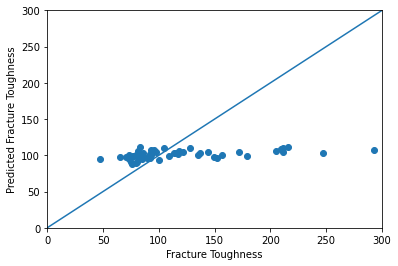

In [88]:
svr_pipeline(ss304)

r2 score for training:  0.11189264057980741
r2 score for testing:  0.08864299157464195


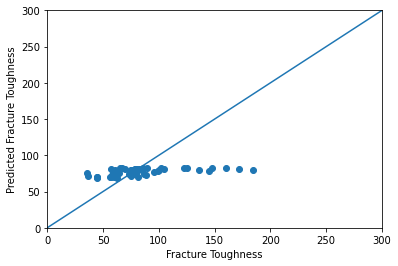

In [89]:
svr_pipeline(ss316)

r2 score for training:  0.0926409951934396
r2 score for testing:  0.22293340379526239


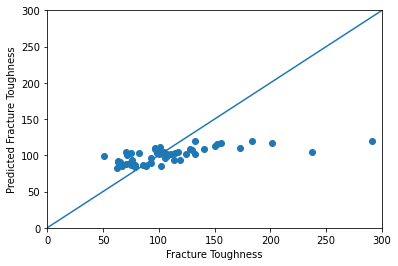

In [90]:
svr_pipeline(ss347)

## Random Forest Regressor

In [94]:
def rf_pipeline(mat_df):
    mat_df = mat_df.drop(columns=["Type"])
    
    X_train, X_test, y_train, y_test = train_test_split(mat_df.drop(columns=['KJIC']), 
                                                                mat_df['KJIC'], 
                                                                test_size=0.2, 
                                                                random_state=2020)
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    
    print("r2 score for training: ", r2_score(y_train, model.predict(X_train)))
    print("r2 score for testing: ", r2_score(y_test, y_pred))
    
    
    plt.scatter(y_test, y_pred)
    plt.plot([0, 1000], [0, 1000])
    plt.xlim([0, 300])
    plt.ylim([0, 300])
    plt.xlabel("Fracture Toughness")
    plt.ylabel("Predicted Fracture Toughness")
    
    return 

r2 score for training:  0.8785722806002375
r2 score for testing:  0.18359536659573983


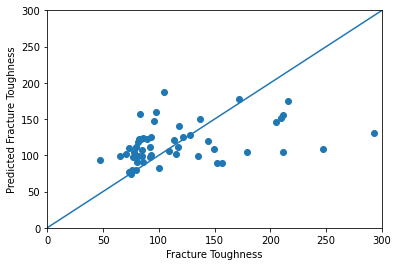

In [95]:
rf_pipeline(ss304)

r2 score for training:  0.8697432270869052
r2 score for testing:  0.3031030507508977


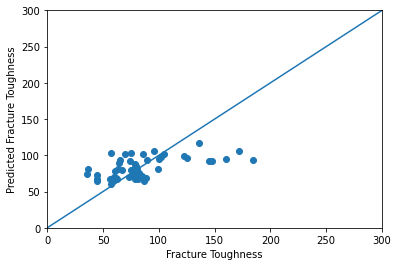

In [97]:
rf_pipeline(ss316)

r2 score for training:  0.9017018276874964
r2 score for testing:  0.03305041545907439


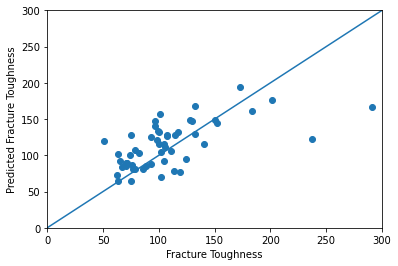

In [99]:
rf_pipeline(ss347)